This is very similar to 8-1_subduction_flux, but we want MOR formation instead. In this notebook we take our C_storage value that we made in notebook 4 and use the data stored there to calculate the amount of carbonate or serpentinite stored in new crust at MOR. We have, of course, two different models (using plate model spreading rates or Pacific Ocean spreading rates) as well as three different ways of measuring uncertainty (see notebook 3); full, batch or individual. We prefer to use 'batch' uncertainty, as it plays a midpoint between full and individual, thus accommodating the inherent uncertainty in spreading rates in the plate model. For serpentinite it is recommended not use 'full' as the bimodal distribution will produce a very (very) large error bar.

In [1]:
import numpy as np
import pandas as pd
import pygplates
import pickle
from collections import defaultdict
import csv

/Users/Andrew/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1066: UserWarning: Duplicate key in file "/Users/Andrew/.matplotlib/matplotlibrc", line #3
  (fname, cnt))
/Users/Andrew/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1066: UserWarning: Duplicate key in file "/Users/Andrew/.matplotlib/matplotlibrc", line #4
  (fname, cnt))


In [2]:
datadir = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pyGPlates_examples/Merdith_2019_Frontiers/Sample_Data/'
loaddir = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pyGPlates_examples/Merdith_2019_Frontiers/output/'
savedir = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pyGPlates_examples/Merdith_2019_Frontiers/output/results/'

# import previously made file of crustal properties
#separate load so faster if we need to recheck stuff
C_storage_POSR = pickle.load(open('%sC_storage_2020-03-13_POSR.p' % datadir, 'rb'))
C_storage_PMSR = pickle.load(open('%sC_storage_2020-03-13_PMSR.p' % datadir, 'rb'))


In [3]:
def running_mean(x, N, mode):
    
    '''
    uses np.convolve to return a running mean.
    X: 1D array or list of values to compute running mean
    N: window size of running mean
    mode: valid, full or same (see https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
    for an example of the difference). I default to 'valid'.
    '''
    #x = np.pad(x, (0, N // 2), mode='constant', constant_values = np.nan)
    return np.convolve(x, np.ones((N,))/N, mode=mode)

In [4]:
def get_distribution(variable, method):
    
    '''
    Accesses a pickle file made in '3_Uncertainty_Distributions_per_spreading_rate' which stores a
    distribution of expected variable values at different spreading rates. Three approaches depenting on 'method'.

    Variable (String): What variable (e.g. Carbon, serpentinite) distirbution we want access to.
    Method (String): What distribution method we want to access; (1) individual; (2) batch; (3) full
    
    1) Distribution for each spreading rate is recovered and sampled to perturb
    2) Distirbution for each spreading rate classificaiton is recovered and sampled to perturb
    3) Full distribution for all spreading rates are recovered
    '''
    
    with open('%s%s_thickness_%s.pkl' % (loaddir, variable, method), 'rb') as f:
        distribution = pickle.load(f)
        
    return distribution

In [13]:
#have to check the correct C_storage is open
times = np.arange(0,201,1)
timesteps = len(times)
samples=10000
variable = 'Serp'
model_type = 'PMSR' #POSR PMSR
sum_variable_PMSR = np.zeros([timesteps, samples])
uncertainty_method = 'batch'
distribution = get_distribution(variable, uncertainty_method)

for ind,time in enumerate(times):
    #print time
    perturbation = np.zeros([len(C_storage_PMSR[time]['Spreading Rate']), samples])
    blank_array = np.ones([len(C_storage_PMSR[time]['Spreading Rate']), samples])
    tmp_SR_array = np.round(np.asarray(C_storage_PMSR[0]['Spreading Rate']))
    tmp_SR_array[tmp_SR_array > 100] = 100

    if uncertainty_method == 'individual':
        for i in range(len(perturbation)):
             #if SR == 0:
            if tmp_SR_array[i] == 0:
                perturbation[i,::] = 0
            else:
                perturbation[i,::] = distribution[int(tmp_SR_array[i]-1)]

    if uncertainty_method == 'batch':
        for i in range(len(perturbation)):
            
            if tmp_SR_array[i] == 0:
                perturbation[i,::] = 0
            elif tmp_SR_array[i] <= 20:
                perturbation[i,::] = distribution[0]
            elif 20 < tmp_SR_array[i] <= 40:
                perturbation[i,::] = distribution[1]
            elif 40 < tmp_SR_array[i] <= 70:
                perturbation[i,::] = distribution[2]
            else:
                perturbation[i,::] = distribution[3]

        perturbation = perturbation/perturbation.mean(axis=1)[:,None]
        perturbation[np.isnan(perturbation)] = 0

    if uncertainty_method == 'full':
        for i in range(len(perturbation)):
             #if SR == 0:
            if tmp_SR_array[i] == 0:
                perturbation[i,::] = 0
            else:
                perturbation[i,::] = distribution    
    
    perturbation = perturbation/perturbation.mean(axis=1)[:,None]
    perturbation[np.isnan(perturbation)] = 0    
    

    perturbed_variable =  np.asarray(C_storage_PMSR[time]['Serpentinites_raw'])[:,None]*perturbation

    sum_variable_PMSR[ind,::] = (np.asarray(C_storage_PMSR[time]['Spreading Rate'])[:,None] * \
                      np.asarray(C_storage_PMSR[time]['Boundary-Length'])[:,None] * \
                      perturbed_variable).sum(axis=0)

with open('%s%s_MOR_%s_%s' % (savedir, variable, model_type, uncertainty_method) + '.csv', 'wb') as f:
    writer = csv.writer(f)
    writer.writerows(sum_variable_PMSR)

/Users/Andrew/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in divide
/Users/Andrew/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in divide


In [103]:
#quick and dirty plot to make sure it looks somewhat reasonable
import matplotlib.pyplot as plt

#density serpentinites g/cm3
serpentinites_density = 3.00 #ranges between 2.7-3.3
serpentinites_densitygkm3 = float(serpentinites_density * 100000**3)
S_MT_a = serpentinites_densitygkm3/1000/1000000000/1000000

a = sum_variable_POSR * S_MT_a
b = sum_variable_PMSR * S_MT_a

In [116]:
mean_POSR = np.asarray([np.mean(i) for i in a])
std_POSR = np.asarray([np.std(i) for i in a])

smooth_mean_POSR = running_mean(mean_POSR, 5, 'valid')
smooth_std_POSR = running_mean(std_POSR, 5, 'valid')

mean_PMSR = np.asarray([np.mean(i) for i in b])
std_PMSR = np.asarray([np.std(i) for i in b])

smooth_mean_PMSR = running_mean(mean_PMSR, 5, 'valid')
smooth_std_PMSR = running_mean(std_PMSR, 5, 'valid')

(400, 0)

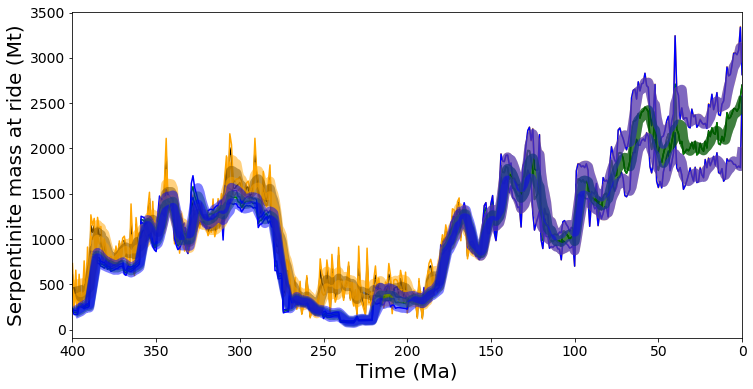

In [117]:
#batch uncertainty
plt.figure(figsize=(12,6))

plt.plot(mean_POSR, color='k')
plt.plot(mean_POSR+std_POSR, color='orange')
plt.plot(mean_POSR-std_POSR, color='orange')

plt.plot(mean_PMSR, color='green')
plt.plot(mean_PMSR+std_PMSR, color='blue')
plt.plot(mean_PMSR-std_PMSR, color='blue')

plt.plot(smooth_mean_POSR, color='k', lw=10, alpha=0.5)
plt.plot(smooth_mean_POSR+smooth_std_POSR, color='orange', lw=10, alpha=0.5)
plt.plot(smooth_mean_POSR-smooth_std_POSR, color='orange', lw=10, alpha=0.5)

plt.plot(smooth_mean_PMSR, color='green', lw=10, alpha=0.5)
plt.plot(smooth_mean_PMSR+smooth_std_PMSR, color='blue', lw=10, alpha=0.5)
plt.plot(smooth_mean_PMSR-smooth_std_PMSR, color='blue', lw=10, alpha=0.5)

plt.xlabel('Time (Ma)', fontsize=20)
plt.ylabel('Serpentinite mass at ride (Mt)', fontsize=20)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(400,0)